In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import scipy.io as io
from pyDOE import lhs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from complexPyTorch.complexLayers import ComplexLinear

import cplxmodule
from cplxmodule import cplx
from cplxmodule.nn import RealToCplx, CplxToReal, CplxSequential, CplxToCplx
from cplxmodule.nn import CplxLinear, CplxModReLU, CplxAdaptiveModReLU, CplxModulus, CplxAngle

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
# from lightning_utils import *
from utils import *
from models import (TorchComplexMLP, ImaginaryDimensionAdder, cplx2tensor, 
                    ComplexTorchMLP, ComplexSymPyModule, complex_mse)
from models import RobustPCANN
from preprocess import *

# Model selection
# from sparsereg.model import STRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from RegscorePy.bic import bic

from madgrad import MADGRAD

Running Python 3.9.8
You can use npar for np.array


In [2]:
# torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You're running on", device)

DATA_PATH = '../PDE_FIND_experimental_datasets/harmonic_osc.mat'
data = io.loadmat(DATA_PATH)

xlimit = 512
tlimit = 161

x = data['x'][0][:xlimit]
t = data['t'][:,0][:tlimit]

spatial_dim = x.shape[0]
time_dim = t.shape[0]

potential = np.vstack([0.5*np.power(x,2).reshape((1,spatial_dim)) for _ in range(time_dim)])
X, T = np.meshgrid(x, t)
Exact = data['usol'][:tlimit, :xlimit]

You're running on cpu


In [3]:
def fn(e): return e.flatten()[:, None]

In [4]:
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)

# Converting in a feature vector for each feature
X_star = np.hstack((fn(X), fn(T)))
h_star = fn(Exact)
potential = fn(potential)

# Doman bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

N = 20000
idx = np.random.choice(X_star.shape[0], N, replace=False)
# idx = np.arange(N) # Just have an easy dataset for experimenting

lb = to_tensor(lb, False).to(device)
ub = to_tensor(ub, False).to(device)

X_train = X_star[idx, :]
h_train = h_star[idx, :]
u_train = np.real(h_train)
v_train = np.imag(h_train)
V = potential[idx, :]

# adding noise
noise_intensity = 0.01/np.sqrt(2)
noisy_xt = True; noisy_labels = True
if noisy_labels:
    u_train = perturb(u_train, noise_intensity)
    v_train = perturb(v_train, noise_intensity)
    h_train = u_train+1j*v_train
    # h_train = 
    print("Noisy labels")
else: print("Clean labels")
if noisy_xt:
    X_train = perturb2d(X_train, noise_intensity)
    print("Noisy (x, t)")
else: print("Clean X_train")

# Converting to tensor
X_star = to_tensor(X_star, True)
h_star = to_complex_tensor(h_star, False)
X_train = to_tensor(X_train, True).to(device)
u_train = to_tensor(u_train, False).to(device)
v_train = to_tensor(v_train, False).to(device)
h_train = torch.tensor(h_train, dtype=torch.cfloat, requires_grad=False).to(device)
V = to_tensor(V, False).to(device)

feature_names = ['hf', 'h_xx', 'V']

Noisy labels
Noisy (x, t)


#### Denoising using DFT

In [5]:
noise_x, x_fft, x_PSD = fft1d_denoise(to_tensor(X_train[:, 0:1]), c=-0.05, return_real=True)
noise_x = X_train[:, 0:1] - noise_x
noise_t, t_fft, t_PSD = fft1d_denoise(to_tensor(X_train[:, 1:2]), c=-0.05, return_real=True)
noise_t = X_train[:, 1:2] - noise_t
X_train_S = cat(noise_x, noise_t)

h_train_S, h_train_fft, h_train_PSD = fft1d_denoise(h_train, c=-0.05, return_real=False)
h_train_S = h_train - h_train_S

del noise_x, noise_t

/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_qho/../utils.py:188: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(arr).float().requires_grad_(g)


In [6]:
# 1st stage results
# clean all
# PDE derived using STRidge
# u_t = (-0.000337 +0.497526i)h_xx
#     + (-0.001670 -0.997429i)hf V
# 161x512
# u_t = (-0.000722 +0.499001)h_xx
#     + (-0.002967 -1.000228i)hf V
# noisy1
# PDE derived using STRidge
# u_t = (0.000702 +0.495803i)h_xx
#     + (0.000641 -0.994030i)hf V
# noisy2
# PDE derived using STRidge
# u_t = (-0.001146 +0.487772i)h_xx
#     + (-0.001516 -0.989395i)hf V

mode = int(noisy_xt)+int(noisy_labels)

if mode == 0:
    cn1 = (-0.00255341-1.0000252*1j)
    cn2 = (-0.0003066+0.4989754*1j)
    name = "cleanall"
elif mode == 1:
    cn1 = (-0.01853757-0.931975*1j)
    cn2 = (-0.01092263+0.47892907*1j)
    name = "noisy1"
elif mode == 2:
    cn1 = (-0.01606621-0.9476085*1j)
    cn2 = (-0.04285275+0.48442504*1j)
    name = "noisy2"
    
cns = [cn1, cn2]

In [7]:
# Type the equation got from the symbolic regression step
# No need to save the eq save a pickle file before
program1 = "X0*X2"
pde_expr1, variables1 = build_exp(program1); print(pde_expr1, variables1)

program2 = "X1"
pde_expr2, variables2 = build_exp(program2); print(pde_expr2, variables2)

mod = ComplexSymPyModule(expressions=[pde_expr1, pde_expr2], complex_coeffs=cns); mod.train()

X0*X2 {X0, X2}
X1 {X1}


ComplexSymPyModule(
  (sympymodule): SymPyModule(expressions=(X0*X2, X1))
)

In [8]:
class PDEExpression(nn.Module):
    def __init__(self, terms, values, symbolic_module=True):
        super(PDEExpression, self).__init__()
        self.terms = terms
        self.values = [complex(e) for e in values]
        self.diff_dict = dict(zip(self.terms, self.values))
        self.string_expression = '+'.join([str(v)+'*'+str(k) for k, v in self.diff_dict.items()])
        pde_expr, self.variables = build_exp(self.string_expression)
        print("Constructing", pde_expr, self.variables)
        self.pde_expr = None
        if symbolic_module:
            self.pde_expr = sympytorch.SymPyModule(expressions=[pde_expr])
            
    # Computing the approx u_t
    def forward(self, e): return self.pde_expr(e)
    # Get a coeff
    def get_coeff(self, t): return self.diff_dict[t]

mod = PDEExpression(["hf*V", "h_xx"], cns, False)

Constructing -1.0*V*hf*(0.01606621 + 0.9476085*I) - 1.0*h_xx*(0.04285275 - 0.48442504*I) {h_xx, V, hf}


In [9]:
class ComplexPINN(nn.Module):
    def __init__(self, model, loss_fn, index2features, scale=False, lb=None, ub=None, init_cs=(-0.05, -0.05), init_betas=(0.0, 0.0)):
        super(ComplexPINN, self).__init__()
        self.model = model
        
        # Setting the parameters up
        self.initial_param0 = loss_fn.get_coeff("hf*V")
        self.initial_param1 = loss_fn.get_coeff("h_xx")
        self.param0_real = nn.Parameter(torch.FloatTensor([self.initial_param0.real]))
        self.param0_imag = nn.Parameter(torch.FloatTensor([self.initial_param0.imag]))
        self.param1_real = nn.Parameter(torch.FloatTensor([self.initial_param1.real]))
        self.param1_imag = nn.Parameter(torch.FloatTensor([self.initial_param1.imag]))
        
        global N
        self.in_fft_nn = FFTTh(c=init_cs[0], func=lambda x: (torch.exp(-F.relu(x))))
        self.out_fft_nn = FFTTh(c=init_cs[1], func=lambda x: (torch.exp(-F.relu(x))))
        # Beta-Robust PCA
        self.inp_rpca = RobustPCANN(beta=init_betas[0], is_beta_trainable=True, inp_dims=2, hidden_dims=32)
        self.out_rpca = RobustPCANN(beta=init_betas[1], is_beta_trainable=True, inp_dims=2, hidden_dims=32)
        
        self.index2features = index2features; self.feature2index = {}
        for idx, fn in enumerate(self.index2features): self.feature2index[fn] = str(idx)
        
        self.scale = scale; self.lb, self.ub = lb, ub
        if self.scale and (self.lb is None or self.ub is None): 
            print("Please provide thw lower and upper bounds of your PDE.")
            print("Otherwise, there will be error(s)")
        
        self.diff_flag = diff_flag(self.index2features)
        
    def forward(self, x, t):
        H = torch.cat([x, t], dim=1)
        if self.scale: H = self.neural_net_scale(H)
        return self.model(H)
    
    def loss(self, X_input, X_input_S, y_input, y_input_S, update_pde_params=True, pure_imag=False, denoise=False):
        total_loss = []
        
        if denoise:
            # Denoising FFT on (x, t)
            X_input_S = cat(torch.fft.ifft(self.in_fft_nn(X_input_S[1])*X_input_S[0]).real.reshape(-1, 1), 
                     torch.fft.ifft(self.in_fft_nn(X_input_S[3])*X_input_S[2]).real.reshape(-1, 1))
            X_input_S = X_input - X_input_S
            X_input = self.inp_rpca(X_input, X_input_S, normalize=True)

            # Denoising FFT on y_input
            y_input_S = y_input-torch.fft.ifft(self.out_fft_nn(y_input_S[1])*y_input_S[0]).reshape(-1, 1)
            y_input = self.out_rpca(cat(y_input.real, y_input.imag), 
                                    cat(y_input_S.real, y_input_S.imag), 
                                    normalize=True)
            y_input = torch.complex(y_input[:, 0:1], y_input[:, 1:2])
        
        # Compute losses
        grads_dict, u_t = self.grads_dict(X_input[:, 0:1], X_input[:, 1:2])
        X0 = cplx2tensor(grads_dict['X0'])
        
        # MSE Loss
        total_loss.append(complex_mse(X0, y_input))
            
        # PDE Loss
        param0 = torch.complex(self.param0_real, self.param0_imag)
        param1 = torch.complex(self.param1_real, self.param1_imag)
        if not update_pde_params: param0, param1 = param0.detach(), param1.detach()
        u_t_pred = (param0*X0*grads_dict['X2'])+(param1*grads_dict['X1'])
        total_loss.append(complex_mse(u_t_pred, u_t))
        
        if pure_imag:
            total_loss.append(torch.linalg.norm(param0.real, 1)+torch.linalg.norm(param1.real, 1))
            
        return total_loss
    
    def grads_dict(self, x, t):
        uf = self.forward(x, t)
        u_t = complex_diff(uf, t)
        
        ### PDE Loss calculation ###
        # Without calling grad
        derivatives = {}
        derivatives['X0'] = uf
        derivatives['X1'] = complex_diff(complex_diff(uf, x), x)
        derivatives['X2'] = 0.5*torch.pow(x, 2)
        
        return derivatives, u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))

    def neural_net_scale(self, inp): 
        return 2*(inp-self.lb)/(self.ub-self.lb)-1

In [10]:
inp_dimension = 2
act = CplxToCplx[torch.tanh]
complex_model = CplxSequential(
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 100, bias=True),
                            act(),
                            CplxLinear(100, 1, bias=True),
                            )

complex_model = torch.nn.Sequential(
                                    torch.nn.Linear(inp_dimension, 200),
                                    RealToCplx(),
                                    complex_model
                                    )

In [11]:
# Pretrained model
semisup_model_state_dict = cpu_load("./new_saved_path/clean_all_161x512_pretrained_semisup_model.pth")
parameters = OrderedDict()

# Filter only the parts that I care about renaming (to be similar to what defined in TorchMLP).
inner_part = "network.model."
for p in semisup_model_state_dict:
    if inner_part in p:
        parameters[p.replace(inner_part, "")] = semisup_model_state_dict[p]
complex_model.load_state_dict(parameters)

pinn = ComplexPINN(model=complex_model, loss_fn=mod, index2features=feature_names, scale=True, lb=lb, ub=ub)
pinn = load_weights(pinn, "/Users/pongpisit/Desktop/kuramoto-sivashinsky-solver/qho_weights/noisy2_161x512_dft_pinn (fixed).pth")

Loaded the model's weights properly


In [12]:
complex_mse(pinn(*dimension_slicing(X_star)).detach(), h_star).item()

0.0005227134097367525

In [13]:
pinn.param0_real.requires_grad_(False)
pinn.param0_imag.requires_grad_(False)
pinn.param1_real.requires_grad_(False)
pinn.param1_imag.requires_grad_(False)

Parameter containing:
tensor([0.4844])

In [14]:
denoise = True
pure_imag = (mode == 0)
update_pde_params = True

def mtl_closure():
    global X_train, h_train, update_pde_params, pure_imag
    if torch.is_grad_enabled(): optimizer1.zero_grad(set_to_none=True)
    losses = pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), 
                       h_train, (h_train_fft, h_train_PSD), 
                       update_pde_params=update_pde_params, pure_imag=True, denoise=denoise)
    l = sum(losses)
    if l.requires_grad: l.backward(retain_graph=True)
    return l

def closure():
    global X_train, h_train, update_pde_params, pure_imag
    if torch.is_grad_enabled(): optimizer2.zero_grad(set_to_none=True)
    losses = pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), 
                      h_train, (h_train_fft, h_train_PSD), 
                      update_pde_params=update_pde_params, pure_imag=pure_imag, denoise=denoise)
    l = sum(losses)
    if l.requires_grad: l.backward(retain_graph=True)
    return l

In [15]:
if pure_imag: epochs1, epochs2 = 30, 0
else: epochs1, epochs2 = 30, 20

In [16]:
epochs1, epochs2 = 0, 0

In [17]:
optimizer1 = MADGRAD(pinn.parameters(), lr=1e-7, momentum=0.90)
pinn.train(); best_train_loss = 1e6

print('1st Phase optimization using Adam with PCGrad gradient modification')
for i in range(epochs1):
    optimizer1.step(mtl_closure)
    l = mtl_closure()
    if (i % 10) == 0 or i == epochs1-1:
        print("Epoch {}: ".format(i), l.item())
        p1 = torch.complex(pinn.param0_real, pinn.param0_imag).detach().numpy()
        p2 = torch.complex(pinn.param1_real, pinn.param1_imag).detach().numpy()
        print(p1)
        print(p2)
        e1 = p1+1j
        e2 = p2-0.5j
        errs = np.abs(npar([100*(np.abs(e1.real)+1j*np.abs(e1.imag))[0], 200*(np.abs(e2.real)+1j*np.abs(e2.imag))[0]]))
        print(errs.mean(), errs.std())

1st Phase optimization using Adam with PCGrad gradient modification


In [18]:
optimizer2 = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=500, max_eval=int(500*1.25), history_size=300, line_search_fn='strong_wolfe')
print('2nd Phase optimization using LBFGS')
for i in range(epochs2):
    optimizer2.step(closure)
    l = closure()
    if (i % 5) == 0 or i == epochs2-1:
        print("Epoch {}: ".format(i), l.item())
        p1 = torch.complex(pinn.param0_real, pinn.param0_imag).detach().numpy()
        p2 = torch.complex(pinn.param1_real, pinn.param1_imag).detach().numpy()
        print(p1)
        print(p2)
        e1 = p1+1j
        e2 = p2-0.5j
        errs = np.abs(npar([100*(np.abs(e1.real)+1j*np.abs(e1.imag))[0], 200*(np.abs(e2.real)+1j*np.abs(e2.imag))[0]]))
        print(errs.mean(), errs.std())

2nd Phase optimization using LBFGS


In [19]:
# plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.style.use('science')
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [20]:
true_norm = torch.sqrt(h_star.real**2 + h_star.imag**2).detach().numpy()

In [21]:
pred_norm = pinn(X_star[:, 0:1], X_star[:, 1:2])
pred_norm = torch.sqrt(pred_norm.real**2 + pred_norm.imag**2).detach().numpy()

In [22]:
complex_mse(pinn(X_star[:, 0:1], X_star[:, 1:2]), h_star)

tensor(0.0005, grad_fn=<AddBackward0>)

In [23]:
relative_l2_error(true_norm, pred_norm)

0.038328134

In [24]:
true_norm = true_norm.reshape(X.shape)
pred_norm = pred_norm.reshape(X.shape)

In [25]:
cns

[(-0.01606621-0.9476085j), (-0.04285275+0.48442504j)]

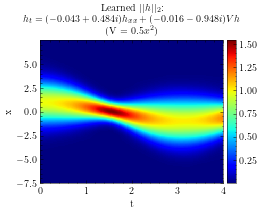

In [26]:
fig, ax = plt.subplots(1, 1)

h = ax.imshow(pred_norm.T, interpolation='nearest', cmap='jet', 
          extent=[lb[1], ub[1], lb[0], ub[0]], 
          origin='lower', aspect='auto')

# ax.set_title("Learned $||h||_{2}$:\n$h_t = (-0.000+0.499i)h_{xx}+(-0.003-1.000i)Vh$\n(V = $0.5x^{2})$", fontsize = 10)
ax.set_title("Learned $||h||_{2}$:\n$h_t = (-0.043+0.484i)h_{xx}+(-0.016-0.948i)Vh$\n(V = $0.5x^{2})$", fontsize = 10)
# ax.set_title("Learned $||h||_{2}$:\n$h_t = (-0.011+0.479i)h_{xx}+(-0.019-0.932i)Vh$\n(V = $0.5x^{2})$", fontsize = 10)
ax.set_xlabel('t')
ax.set_ylabel('x')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig("./vis_pics/Learned_Dynamics_noisy2.png", dpi=300)
plt.show()

In [15]:
p1 = torch.complex(pinn.param0_real, pinn.param0_imag).detach().numpy()
p2 = torch.complex(pinn.param1_real, pinn.param1_imag).detach().numpy()
print(p1)
print(p2)
e1 = p1+1j
e2 = p2-0.5j
errs = np.abs(npar([100*(np.abs(e1.real)+1j*np.abs(e1.imag))[0], 200*(np.abs(e2.real)+1j*np.abs(e2.imag))[0]]))
print(errs.mean(), errs.std())

[-0.00119969-0.99951124j]
[2.2208438e-05+0.49888238j]
0.17655531381856732 0.04701219112781797


In [16]:
save(pinn, "clean_all_161x512_dft_pinn.pth")

#### Sanity check

In [ ]:
# from pde_diff import TrainSTRidge, FiniteDiff, print_pde

In [ ]:
# gd, u_t = pinn.grads_dict(X_train[:, 0:1], X_train[:, 1:2])
# uf = cplx2tensor(gd['X0']).detach().numpy()
# u_xx = gd['X1'].detach().numpy()
# V = gd['X2'].detach().numpy()
# diffs = np.hstack((uf*V, u_xx))

In [ ]:
# w = TrainSTRidge(diffs, to_numpy(u_t), 1e-6, d_tol=5)
# print("PDE derived using STRidge")
# print_pde(w, mod.terms)